# Soil Storage Capacity

In [8]:
from pathlib import Path

import matplotlib.pyplot as plt

import pygeohydro as gh
from pynhd import NLDI
import pygeoutils as geoutils

Some hydrological models have a parameter related the max soil storage capacity of watersheds. A simple way of estimating this parameter is to use porosity and thickness properties of a watershed soil. In this tutorial, we retrieve these data from two soil datasets that PyGeoHydro supports. PyGeoHydro has two functions for getting soil data:

- `soil_gnatsgo`: You can access all soil properties that are available on [gNATSGO](https://planetarycomputer.microsoft.com/dataset/gnatsgo-rasters#overview) dataset
- `soil_properties`: Porosity, available water capacity, and field capacity properties are available through this function.

Let's start by getting the basin geometry of the USGS station 11092450 using PyNHD:

In [2]:
basin = NLDI().get_basins("11092450")
geom = basin.geometry[0]

Next, we get the soil porosity. Note that `soil_properties` return the requested property for the whole US. But, thanks to `dask` and `xarray`, the dataset is loaded lazily, so we don't have to worry about memory usage. This function downloads the requested dataset(s) each of which is around 300 MB, so the first time that you run this function it can take a few minutes, depending on your internet speed. However, after it gets downloaded once, next calls to this function uses the downloaded file, so it will be quick. By default, downloaded files are saved to `./cache` folder, but you can specify a custom directory to save the `zip` files.

If you run this function without any arguments, it downloads all three soil properties and returns them as a single dataset. You can pass one or more of soil properties: `por` for porosity, `awc` for available water capacity, and `fc` for field capacity.

In [3]:
soil = gh.soil_properties("por")

Now, we can mask this large dataset to our basin geometry using PyGeoUtils.

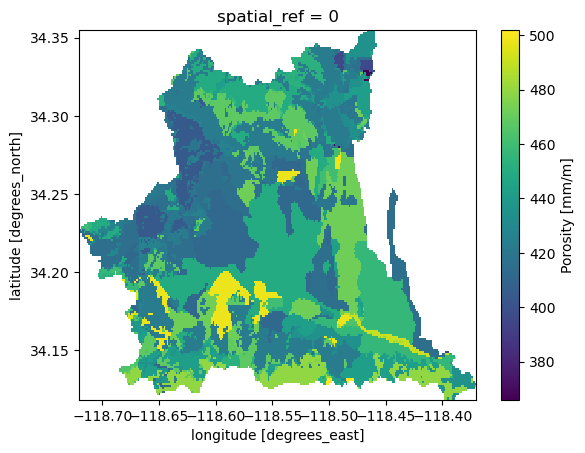

In [4]:
soil = geoutils.xarray_geomask(soil, geom, basin.crs)
soil = soil.where(soil.porosity > soil.porosity.rio.nodata)
_ = soil.porosity.plot()

Now that we have the porosity, we need to get soil thickness. We use Microsoft's Planetary Computer service using `soil_gnatsgo` function. This function has two additional dependencies that need to be installed: `pystac-client` and `planetary-computer`. They can be installed using `conda` or `mamba` as follows:

```bash
mamba -c conda-forge install pystac-client planetary-computer
```

We use `tk0_999a` later to get the total soil thickness. You can check out the full description the layer and other available layers from the dataset's [webpage](https://planetarycomputer.microsoft.com/dataset/gnatsgo-rasters).

In [5]:
thickness = gh.soil_gnatsgo("tk0_999a", geom, basin.crs)

Using `thickness.rio.resolution()` and `soil.rio.resolution()` we can see that the resolution of the thickness dataset is 10 m whereas that of the porosity is around 90 m. So, we should resample the dataset with finer resolution, thickness, to the coarser one. For this purpose we use `rioxarray.reproject_match` function. For resampling, we use the weighted averaging function of `rasterio`. Therefore, we need to 5 as the resampling method. The full list of supported resampling operations can be found on `rasterio` [webpage](https://rasterio.readthedocs.io/en/stable/api/rasterio.enums.html#rasterio.enums.Resampling).

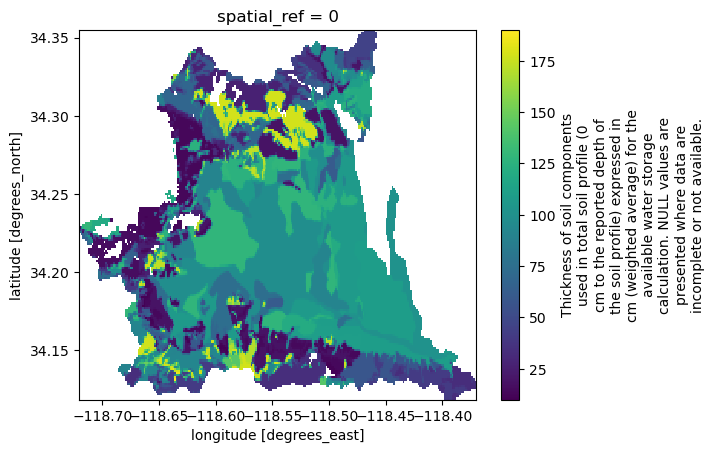

In [6]:
soil["thickness"] = thickness.tk0_999a.rio.reproject_match(soil, resampling=5)
_ = soil["thickness"].plot()

Considering that porosity is in mm/m and thickness is in cm, we can compute the storage capacity as follows:

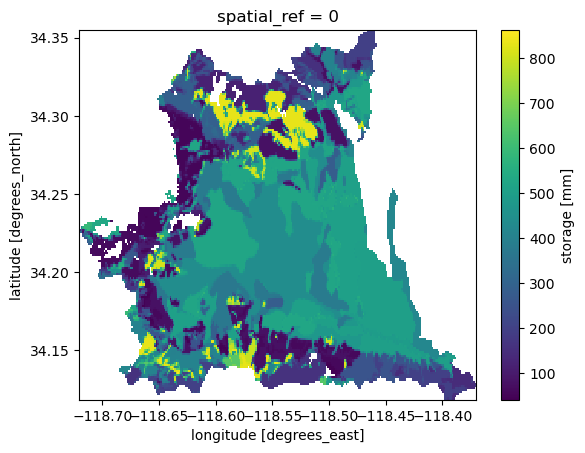

In [10]:
soil["storage"] = soil.porosity * soil.thickness * 0.01
soil["storage"].attrs["units"] = "mm"
soil["storage"].plot()
plt.savefig(Path("_static", "soil_storage.png"), dpi=150)